### Custom embedder for parametric UMAP. 
This notebook shows you how to run a UMAP projection with a custom embedder. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

### load data

In [2]:
from torchvision import datasets, transforms

# Download and load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Convert PyTorch tensor to NumPy array
train_images = mnist_train.data.numpy()
train_labels = mnist_train.targets.numpy()
train_images = train_images.reshape((train_images.shape[0], -1))/255.
train_images.shape, train_labels.shape

((60000, 784), (60000,))

### create parametric umap model

In [3]:
from umap.parametric_umap import ParametricUMAP

/n/groups/datta/tim_sainburg/conda_envs/parametricumap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
embedder = ParametricUMAP(
    global_correlation_loss_weight = 0.1, 
    n_epochs=25,
    verbose=True
)

In [5]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(global_correlation_loss_weight=0.1)
Fri May 17 09:19:33 2024 Construct fuzzy simplicial set
Fri May 17 09:19:33 2024 Finding Nearest Neighbors
Fri May 17 09:19:33 2024 Building RP forest with 17 trees
Fri May 17 09:19:37 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri May 17 09:19:48 2024 Finished Nearest Neighbor Search
Fri May 17 09:19:51 2024 Construct embedding
Epoch 1/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - global_correlation_loss: -0.0656 - loss: 0.1898 - umap_loss: 0.2553
Epoch 2/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - global_correlation_loss: -0.0632 - loss: 0.1429 - umap_loss: 0.2061
Epoch 3/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - global_correlation_loss: -0.0619 - loss: 0.1361 - umap_loss: 0.1980
Epoch 4/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - global_correlation_loss: -0.0611 - loss: 0.1329 - umap_loss: 0.1941
Epoch 5/10
923/923 ━━━━━━━━━━━━━━

In [6]:
embedder._history.keys()

dict_keys(['global_correlation_loss', 'loss', 'umap_loss'])

### plot results

In [8]:
embedding = embedder.embedding_

In [9]:
import matplotlib.pyplot as plt

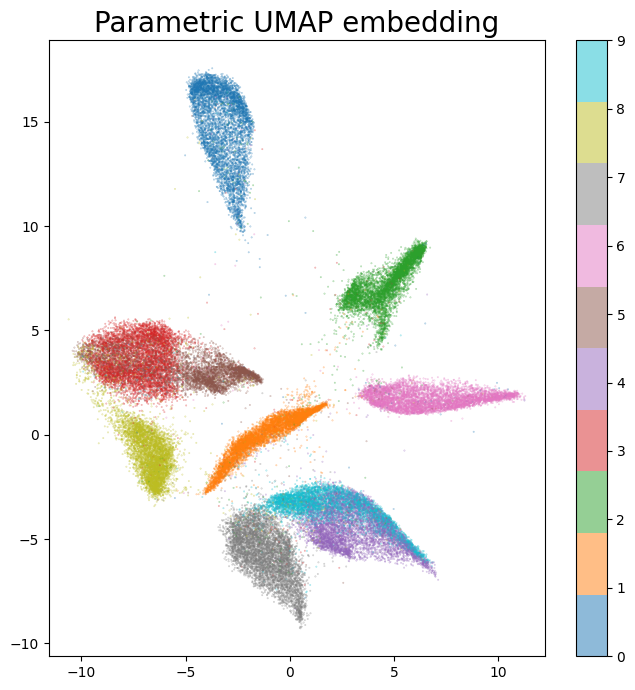

In [10]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_labels.astype(int)[:len(embedding)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Parametric UMAP embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### measure at global structure as correlation of pairwise distances

In [11]:
import numpy as np
import scipy.stats
import sklearn

In [12]:
nex = 1000
sample1 = np.random.randint(len(train_images), size=nex)
sample2 = np.random.randint(len(train_images), size=nex)
x1 = train_images[sample1]
x2 = train_images[sample2]
z1 = embedding[sample1]
z2 = embedding[sample2]
x_dist = sklearn.metrics.pairwise_distances(x1, x2).flatten()

z_dist = sklearn.metrics.pairwise_distances(z1, z2).flatten()

corr, p = scipy.stats.pearsonr(x_dist, z_dist)
print("r^2={}, p={}".format(corr, p))

r^2=0.5661054474710483, p=0.0


In [14]:
bins

array([ 0.        ,  0.80988037,  1.61976075,  2.42964112,  3.23952149,
        4.04940187,  4.85928224,  5.66916262,  6.47904299,  7.28892336,
        8.09880374,  8.90868411,  9.71856448, 10.52844486, 11.33832523,
       12.14820561, 12.95808598, 13.76796635, 14.57784673, 15.3877271 ])

In [16]:
np.unique(xbins)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])

Text(0, 0.5, 'Embedding distances')

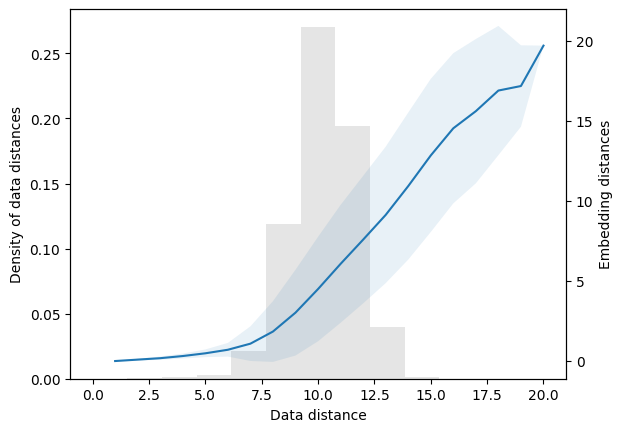

In [17]:
fig, ax = plt.subplots()

ax.hist(x_dist, color = 'k', alpha = 0.1, density=True)
ax.set_ylabel('Density of data distances')
ax.set_xlabel('Data distance')

ax2 = ax.twinx()
bins = np.linspace(np.min(x_dist), np.max(x_dist), 20)
xbins = np.digitize(x_dist, bins = bins)
bins = np.unique(xbins)
zmean = np.array([np.mean(z_dist[xbins == i]) for i in bins])
zstd = np.array([np.std(z_dist[xbins == i]) for i in bins])
ax2.plot(bins, zmean)
ax2.fill_between(bins, zmean-zstd, zmean+zstd, alpha = 0.1)
ax2.set_ylabel('Embedding distances')


### plotting loss

In [18]:
embedder._history.keys()

dict_keys(['global_correlation_loss', 'loss', 'umap_loss'])

Text(0, 0.5, 'global_correlation_loss')

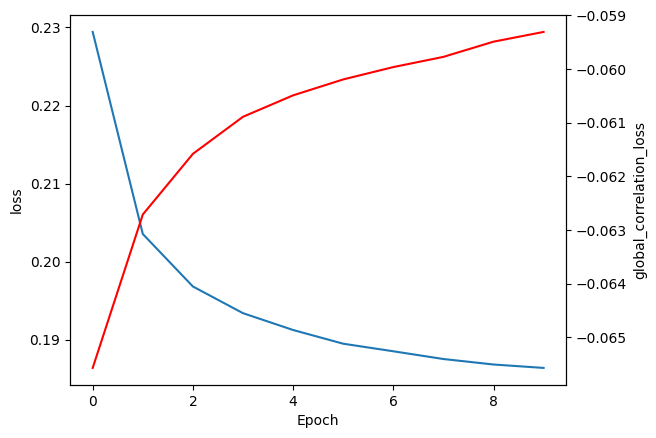

In [19]:
fig, ax = plt.subplots()
ax.plot(embedder._history['umap_loss'])
ax.set_ylabel('loss')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(embedder._history['global_correlation_loss'], color = 'r')
ax2.set_ylabel('global_correlation_loss')


## Repeat with more global structure

### create parametric umap model

In [20]:
embedder = ParametricUMAP(
    global_correlation_loss_weight = 1.0,
    n_epochs=25,
    verbose=True
)

In [21]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(global_correlation_loss_weight=1.0)
Fri May 17 10:19:07 2024 Construct fuzzy simplicial set
Fri May 17 10:19:07 2024 Finding Nearest Neighbors
Fri May 17 10:19:07 2024 Building RP forest with 17 trees
Fri May 17 10:19:07 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri May 17 10:19:10 2024 Finished Nearest Neighbor Search
Fri May 17 10:19:10 2024 Construct embedding
Epoch 1/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - global_correlation_loss: -0.7452 - loss: -0.4435 - umap_loss: 0.3017
Epoch 2/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - global_correlation_loss: -0.7781 - loss: -0.5148 - umap_loss: 0.2634
Epoch 3/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - global_correlation_loss: -0.7798 - loss: -0.5198 - umap_loss: 0.2600
Epoch 4/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - global_correlation_loss: -0.7790 - loss: -0.5209 - umap_loss: 0.2580
Epoch 5/10
923/923 ━━━━━━━━━━

### plot results

In [22]:
embedding = embedder.embedding_

In [23]:
import matplotlib.pyplot as plt

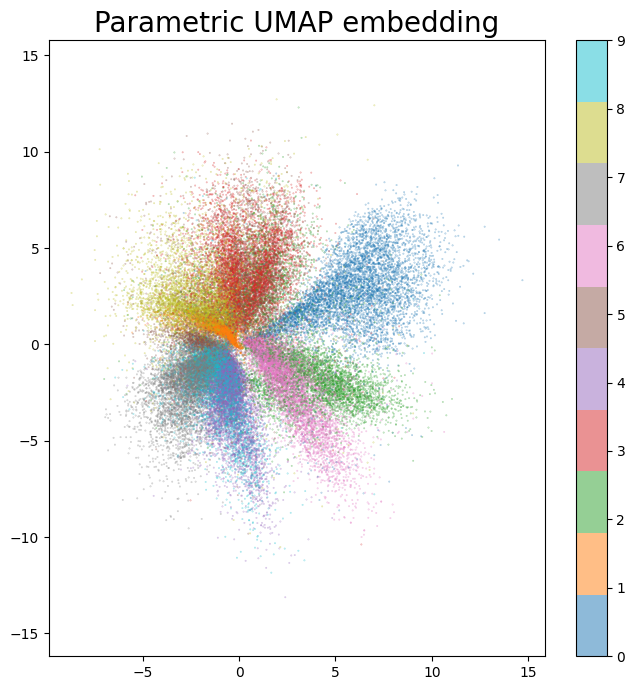

In [24]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_labels.astype(int)[:len(embedding)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Parametric UMAP embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### measure at global structure as correlation of pairwise distances

In [25]:
import numpy as np
import scipy.stats
import sklearn

In [26]:
nex = 1000
sample1 = np.random.randint(len(train_images), size=nex)
sample2 = np.random.randint(len(train_images), size=nex)
x1 = train_images[sample1]
x2 = train_images[sample2]
z1 = embedding[sample1]
z2 = embedding[sample2]
x_dist = sklearn.metrics.pairwise_distances(x1, x2).flatten()

z_dist = sklearn.metrics.pairwise_distances(z1, z2).flatten()

corr, p = scipy.stats.pearsonr(x_dist, z_dist)
print("r^2={}, p={}".format(corr, p))

r^2=0.7740781201878811, p=0.0


In [27]:
np.unique(xbins), len(np.unique(xbins))

(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20]),
 19)

Text(0, 0.5, 'Embedding distances')

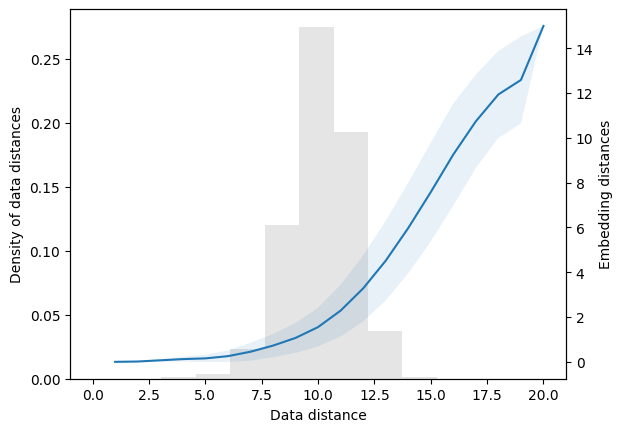

In [28]:
fig, ax = plt.subplots()

ax.hist(x_dist, color = 'k', alpha = 0.1, density=True)
ax.set_ylabel('Density of data distances')
ax.set_xlabel('Data distance')

ax2 = ax.twinx()
bins = np.linspace(np.min(x_dist), np.max(x_dist), 20)
xbins = np.digitize(x_dist, bins = bins)
bins = np.unique(xbins)
zmean = np.array([np.mean(z_dist[xbins == i]) for i in bins])
zstd = np.array([np.std(z_dist[xbins == i]) for i in bins])
ax2.plot(bins, zmean)
ax2.fill_between(bins, zmean-zstd, zmean+zstd, alpha = 0.1)
ax2.set_ylabel('Embedding distances')


### plotting loss

In [29]:
embedder._history.keys()

dict_keys(['global_correlation_loss', 'loss', 'umap_loss'])

In [30]:
embedder.__dict__

{'n_neighbors': 15,
 'metric': 'euclidean',
 'output_metric': 'euclidean',
 'target_metric': 'categorical',
 'metric_kwds': None,
 'output_metric_kwds': None,
 'n_epochs': 25,
 'init': 'spectral',
 'n_components': 2,
 'repulsion_strength': 1.0,
 'learning_rate': 1.0,
 'spread': 1.0,
 'min_dist': 0.1,
 'low_memory': True,
 'set_op_mix_ratio': 1.0,
 'local_connectivity': 1.0,
 'negative_sample_rate': 5,
 'random_state': None,
 'angular_rp_forest': False,
 'transform_queue_size': 4.0,
 'target_n_neighbors': -1,
 'target_metric_kwds': None,
 'target_weight': 0.5,
 'transform_seed': 42,
 'transform_mode': 'embedding',
 'force_approximation_algorithm': False,
 'verbose': True,
 'tqdm_kwds': {'desc': 'Epochs completed',
  'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]'},
 'unique': False,
 'densmap': False,
 'dens_lambda': 2.0,
 'dens_frac': 0.3,
 'dens_var_shift': 0.1,
 'output_dens': False,
 'disconnection_distance': None,
 'precomputed_knn': (None, None, N

Text(0, 0.5, 'global_correlation_loss')

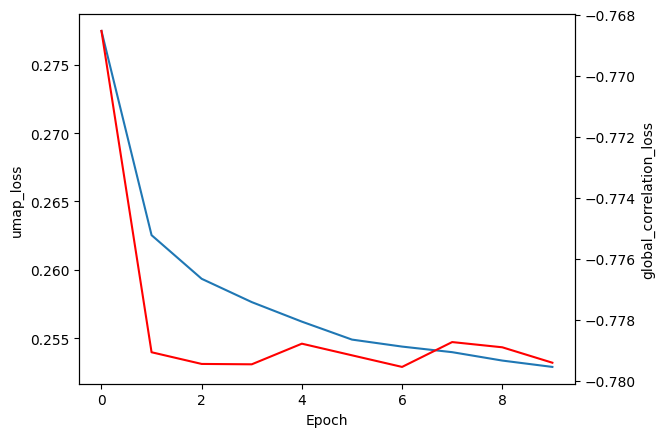

In [31]:
fig, ax = plt.subplots()
ax.plot(embedder._history['umap_loss'])
ax.set_ylabel('umap_loss')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(embedder._history['global_correlation_loss'], color = 'r')
ax2.set_ylabel('global_correlation_loss')
